In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import math

Количество нейронов на входном, скрытом и выходном слоях:

In [2]:
hidden = 3
inputs = 5
outputs = 1

wih = 'weights_input_hidden.npy'
whh = "weights_hidden_hidden.npy"
woh = "weights_output_hidden.npy"
who = "weights_hidden_output.npy"
bh = "context_hidden.npy"
bo = "context_output.npy"

Класс нейронной сети Джордана-Элмана:
В качестве функции активации используется функция гиперболического тангенса, т.к. ни в одном из источников я не нашла информации об использовании функции гиперболического арксинуса в качестве функции активации(соответственно, с ним не работает).

In [3]:
class JordanElmanNetwork:
    def __init__(self, alpha, error, weights_ih=None, weights_hh=None, weights_oh=None,
                 weights_ho=None, bh=None, bo=None):
        self.input = np.zeros((inputs, 1))
        self.hidden = np.zeros((hidden, 1))
        self.S = np.zeros_like(self.hidden)
        self.context = np.zeros((hidden, 1))
        self.output = np.zeros((outputs, 1))
        self.output_prev = self.output

        self.error = error

        if weights_ih is None and weights_hh is None and weights_oh is None:
            self.w_input_hidden = np.random.uniform(-.1, .1, (hidden, inputs))
            self.w_hidden_hidden = np.random.uniform(-.1, .1, (hidden, hidden))
            self.w_output_hidden = np.random.uniform(-.1, .1, (hidden, outputs))  # от предыдущего выхода к скрытому
            self.w_hidden_output = np.random.uniform(-.1, .1, (outputs, hidden))  # от скрытого к выходу
            self.bh = np.zeros_like(self.hidden)
            self.bo = np.zeros_like(self.output)
        else:
            self.w_input_hidden = np.load(weights_ih)
            self.w_hidden_hidden = np.load(weights_hh)
            self.w_hidden_output = np.load(weights_ho)
            self.w_output_hidden = np.load(weights_oh)
            self.bh = np.load(bh)
            self.bo = np.load(bo)

        self.alpha = alpha

    @staticmethod
    def activate(matrix):
        matrix = np.tanh(matrix)
        return matrix

    @staticmethod
    def derivative(value):
        return 1 - np.tanh(value)**2

    def train(self, t):
        error = [[1000000]]
        #while error[0][0]/(len(t)-inputs + 1) > self.error:
        for tries in tqdm(range(300)):
            self.output_prev = np.zeros_like(self.output)
            self.context = np.zeros_like(self.hidden)
            temp_sample = []
            # выборка окна
            error = [[0]]
            for i in range(len(t) - inputs - 1):
                for j in range(i, i + inputs):
                    temp_sample.append(t[j])
                sample = np.array([temp_sample])
                self.S = self.w_input_hidden @ sample.T + self.w_hidden_hidden @ self.context + \
                         self.w_output_hidden @ self.output_prev - self.bh
                self.hidden = self.activate(self.S)
                self.output = self.w_hidden_output @ self.hidden - self.bo

                loss = np.array(self.output - t[i + inputs])
                error += pow(loss, 2) / 2

                gamma = loss * self.w_hidden_output.T
                self.bo += self.alpha * loss
                self.w_input_hidden = self.w_input_hidden - (self.alpha * gamma * self.derivative(self.S)) @ sample
                self.w_hidden_hidden = self.w_hidden_hidden - (self.alpha * gamma * self.derivative(self.S)) @ \
                                       self.context.T
                self.w_output_hidden = self.w_output_hidden - (self.alpha * gamma * self.derivative(self.S)) @ \
                                       self.output_prev.T

                self.bh += self.alpha * gamma * self.derivative(self.S)
                self.w_hidden_output -= self.alpha * loss * self.hidden.T
                self.context = self.hidden
                self.output_prev = self.output

                temp_sample.clear()
        self.save()

    def save(self):
        np.save(wih, self.w_input_hidden)
        np.save(whh, self.w_hidden_hidden)
        np.save(who, self.w_hidden_output)
        np.save(woh, self.w_output_hidden)
        np.save(bh, self.bh)
        np.save(bo, self.bo)

    def predict(self, sample, predict_size):
        self.input = np.zeros((inputs, 1))
        self.hidden = np.zeros((hidden, 1))
        self.S = np.zeros_like(self.hidden)
        self.context = np.zeros((hidden, 1))
        self.output = np.zeros((outputs, 1))
        self.output_prev = self.output

        predict = sample[:inputs]
        for i in tqdm(range(len(sample) - inputs + predict_size)):
            x = np.array([sample[i:i + inputs]]).T
            self.S = self.w_input_hidden @ x + self.w_hidden_hidden @ self.context + \
                     self.w_output_hidden @ self.output_prev - self.bh
            self.hidden = self.activate(self.S)
            self.output = self.w_hidden_output @ self.hidden - self.bo
            self.context = self.hidden
            self.output_prev = self.output
            predict.append(self.output[0][0])
            if i >= len(sample) - inputs:
                sample.append(self.output[0][0])
        return predict

Предсказание последовательности (-1, 0, 1, 0, -1, 0, 1...):

100%|██████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<?, ?it/s]


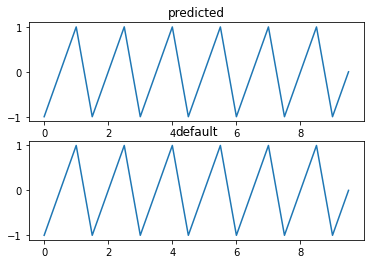

In [4]:
    x = [x/2 for x in range(20)]
    test = []
    for _ in range(334):
        test += [-1, 0, 1]
    test = test[:20]
    n = JordanElmanNetwork(0.1, 1e-6)
    n.train(test)
    p = n.predict(test[:10], 10)

    fig = plt.figure()
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.plot(x, p)
    ax_2.plot(x, test)

    ax_1.set(title='predicted')
    ax_2.set(title='default')

    plt.show()

Предсказание 10 элементов последовательности, определяемой функцией y = (2 / 3) * sin(x / 10) + (2 / 5) * cos(x / 20) + (1 / 2) * sin(x / 30):

100%|██████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<?, ?it/s]


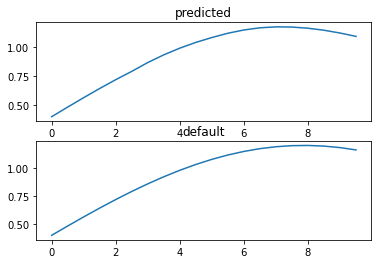

In [7]:
    test = [(2 / 3) * math.sin(x / 10) + (2 / 5) * math.cos(x / 20) + (1 / 2) * math.sin(x / 30) for x in range(30)]
    n = JordanElmanNetwork(0.1, 1e-6)
    n.train(test)
    p = n.predict(test[:10], 10)

    fig = plt.figure()
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.plot(x, p)
    ax_2.plot(x, test[:20])

    ax_1.set(title='predicted')
    ax_2.set(title='default')

    plt.show()

Возрастающие последовательности, у которых область значений выходит за пределы промежутка [-1, 1] (области значений функции активации гиперболического тангенса), плохо предсказываются данной нейронной сетью. Какое бы значение не подавалось на вход нейрона с функцией активации гиперболический тангенс, на выходе будет значение в промежутке от -1 до 1. Условно, при наличии 3-ёх нейронов на скрытом слое и весах, равных 1, максимальное полученное значение - 3. Если нужно получить число, больше 3, то веса становятся ненормализованными(выходят за границы промежутка [-1, 1]), что не является оптимальным.

То есть, из-за того, что область значений [-1, 1], нейронная сеть буде минимизировать ошибку путем увеличения весов.
Ниже приведён пример прогнозирования чисел Фибоначчи.

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 14997.51it/s]


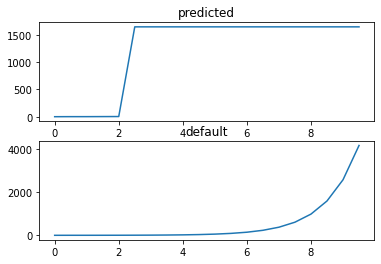

In [9]:
    test = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181]
    n = JordanElmanNetwork(0.1, 1e-6)
    n.train(test)
    p = n.predict(test[:10], 10)

    fig = plt.figure()
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.plot(x, p)
    ax_2.plot(x, test[:20])

    ax_1.set(title='predicted')
    ax_2.set(title='default')

    plt.show()